# Properties of Duo-Rerankers

In [38]:
!nosetests ../tests

import sys
sys.path.insert(0, "../src")
from retrieval_pipelines.FileSystemCache import FileSystemCache
from tqdm import tqdm
import seaborn as sns
import pandas as pd

import pyterrier as pt
if not pt.started():
    pt.init()

DIR = '/mnt/ceph/storage/data-in-progress/data-research/web-search/SIGIR-22/sigir22-pairwise-ranking/pairwise-cache/dl_passages/'

dl_passages = pt.get_dataset('trec-deep-learning-passages')
ALL_CACHES = {}

def duo_t5_cache(model):
    if model not in ALL_CACHES:
        ALL_CACHES[model] = FileSystemCache(DIR + 'castorini-duot5-' + model + '-msmarco')
    
    return ALL_CACHES[model]

....
----------------------------------------------------------------------
Ran 4 tests in 0.002s

OK


### Is DuoT5-3b Symmetrical?

In [144]:
def all_pairs(model_name, shared_task):
    import numpy as np
    
    cache = duo_t5_cache(model_name)
    topics = dl_passages.get_topics(shared_task)
    topics = set(topics['qid'])
    df_qrels = dl_passages.get_qrels(shared_task)
    qrels = {}
    
    for _, i in df_qrels.iterrows():
        qrels[(str(i['qid']), str(i['docno']))] = i['label']
    
    
    ret = []
    already_seen_per_query = {}
    
    for (qid, did1, did2), _ in tqdm([i for i in cache]):
        if qid not in topics:
            continue
        if qid not in already_seen_per_query:
            already_seen_per_query[qid] = set()
        
        if (did1, did2) not in already_seen_per_query[qid]:
            already_seen_per_query[qid].add((did1, did2))
            already_seen_per_query[qid].add((did2, did1))
            
            prop_did1_did2 = np.exp(cache[(qid, did1, did2)])
            prop_did2_did1 = np.exp(cache[(qid, did2, did1)])
            
            rel_a = qrels.get((qid, did1), 0)
            rel_b = qrels.get((qid, did2), 0)
            
            
            
            relevance_id_a_before_id_b = 0
            
            if rel_a > rel_b:
                relevance_id_a_before_id_b = 1
            if rel_a < rel_b:
                relevance_id_a_before_id_b = -1
            
            ret += [{
                'model_name': model_name,
                'qid': qid,
                'shared_task': shared_task,
                'id_a': did1,
                'id_b': did2,
                'both_documents_judged': (qid, did1) in qrels and (qid, did2) in qrels, 
                'propbability_id_a_before_id_b': prop_did1_did2 - prop_did2_did1,
                'relevance_id_a_before_id_b': relevance_id_a_before_id_b,
                'preference_correct': (prop_did1_did2 - prop_did2_did1 > 0 and relevance_id_a_before_id_b > 0) or (prop_did1_did2 - prop_did2_did1 < 0 and relevance_id_a_before_id_b < 0),
                'P(A before B|q)': prop_did1_did2,
                'P(B before A|q)': prop_did2_did1,
                'absoluteScoreDifference': abs(prop_did1_did2 - (1 - prop_did2_did1))
            }]
    
    return ret

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 324661/324661 [00:00<00:00, 483224.77it/s]


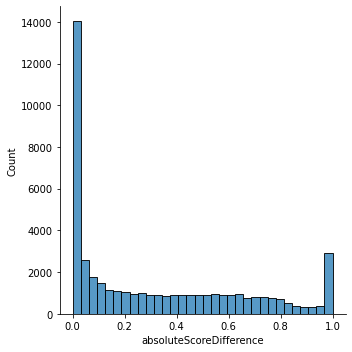

In [145]:
df_3b = pd.DataFrame(all_pairs('3b', 'test-2019'))
sns.displot(data=df_3b[df_3b['both_documents_judged']], x='absoluteScoreDifference')

In [95]:
# Korrelation insgesamt
df_3b[df_3b['both_documents_judged']]['P(A before B|q)'].corr(df_3b[df_3b['both_documents_judged']]['P(B before A|q)']*-1)

0.4072225793126198

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 329041/329041 [00:00<00:00, 496692.37it/s]


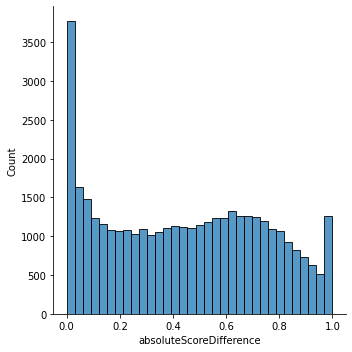

In [146]:
df_base = pd.DataFrame(all_pairs('base', 'test-2019'))
sns.displot(data=df_base[df_base['both_documents_judged']], x='absoluteScoreDifference')

In [147]:
# Korrelation insgesamt
df_base[df_base['both_documents_judged']]['P(A before B|q)'].corr(df_base[df_base['both_documents_judged']]['P(B before A|q)']*-1)

0.16641562537038343

### Is DuoT5-3b Transitive?

In [129]:
def transitive_pairs(model_name, shared_task, threshold):
    import numpy as np
    import itertools
    
    cache = duo_t5_cache(model_name)
    topics = dl_passages.get_topics(shared_task)
    topics = set(topics['qid'])
    df_qrels = dl_passages.get_qrels(shared_task)
    qrels = {}
    
    for _, i in df_qrels.iterrows():
        qrels[(str(i['qid']), str(i['docno']))] = i['label']
    
    
    ret = []
    
    all_elements = {}
    for (qid, did1, did2), _ in tqdm([i for i in cache]):
        if qid not in topics:
            continue
        if qid not in all_elements:
            all_elements[qid] = set()
        
        all_elements[qid].add(did1)
        all_elements[qid].add(did2)
    
    for qid, docs in tqdm(all_elements.items()):
        for (did1, did2, did3) in itertools.permutations(docs, 3):
            if (qid, did1, did2) not in cache or (qid, did2, did3) not in cache or (qid, did1, did3) not in cache:
                continue
            
            prop_did1_did2 = np.exp(cache[(qid, did1, did2)])
            prop_did2_did3 = np.exp(cache[(qid, did2, did3)])
            prop_did1_did3 = np.exp(cache[(qid, did1, did3)])
            
            
            rel_did1 = qrels.get((qid, did1), 0)
            rel_did2 = qrels.get((qid, did2), 0)
            rel_did3 = qrels.get((qid, did3), 0)
            
            ret += [{
                'model_name': model_name,
                'qid': qid,
                'shared_task': shared_task,
                'Precondition transitive fulfilled': prop_did1_did2 > threshold and prop_did2_did3 > threshold,
                'P(A before B|q) + P(B before C|q)': prop_did1_did2 + prop_did2_did3,
                'min(P(A before B|q) + P(B before C|q)) <= P(A before C|q)': min(prop_did1_did2, prop_did2_did3) <= prop_did1_did3,
                'P(A before C|q)': prop_did1_did3,
                'Rel(A)': rel_did1,
                'Rel(B)': rel_did2,
                'Rel(C)': rel_did3,
            }]
    
    return ret

In [130]:
df_3b_transitive = pd.DataFrame(transitive_pairs('3b', 'test-2019', 0.6))

print(len(df_3b_transitive))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [01:06<00:00,  1.54s/it]


9606210


In [134]:
df_3b_transitive['min(P(A before B|q) + P(B before C|q)) <= P(A before C|q)'].mean()

0.792504536128192

In [135]:
df_3b_transitive[df_3b_transitive['Precondition transitive fulfilled']]['min(P(A before B|q) + P(B before C|q)) <= P(A before C|q)'].mean()

0.8414689943031378

In [138]:
df_3b_transitive[df_3b_transitive['Rel(A)'] > df_3b_transitive['Rel(C)']]['min(P(A before B|q) + P(B before C|q)) <= P(A before C|q)'].mean()

0.9363472508854302

In [137]:
df_3b_transitive[df_3b_transitive['Rel(A)'] < df_3b_transitive['Rel(C)']]['min(P(A before B|q) + P(B before C|q)) <= P(A before C|q)'].mean()

0.662044555392338

In [131]:
df_base_transitive = pd.DataFrame(transitive_pairs('base', 'test-2019', 0.6))

print(len(df_base_transitive))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [01:08<00:00,  1.58s/it]


9733416


In [132]:
df_base_transitive['min(P(A before B|q) + P(B before C|q)) <= P(A before C|q)'].mean()

0.7590512929890184

In [133]:
df_base_transitive[df_base_transitive['Precondition transitive fulfilled']]['min(P(A before B|q) + P(B before C|q)) <= P(A before C|q)'].mean()

0.7137520382829479

In [140]:
df_base_transitive[df_base_transitive['Rel(A)'] < df_base_transitive['Rel(C)']]['min(P(A before B|q) + P(B before C|q)) <= P(A before C|q)'].mean()

0.6441515828760079

In [142]:
df_base_transitive[(df_base_transitive['Rel(A)'] > df_base_transitive['Rel(B)']) & (df_base_transitive['Rel(B)'] > df_base_transitive['Rel(C)'])& (df_base_transitive['Rel(A)'] > df_base_transitive['Rel(C)'])]['min(P(A before B|q) + P(B before C|q)) <= P(A before C|q)'].mean()

0.9166944483684136